In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
def fix_crs(map_ob):
    return map_ob.to_crs({'init': 'epsg:4326'})

def df_to_geodf(df):
    return gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'})

UBC_poly = [(-123.26494, 49.26512), (-123.26308, 49.25894), (-123.25409, 49.25118), (-123.22587, 49.23889), (-123.19758, 49.23532),(-123.1979, 49.24501), (-123.2054, 49.24898),(-123.20218, 49.25358),(-123.20382, 49.25832),(-123.21564, 49.25873),(-123.21564, 49.26374),(-123.22793, 49.26326),(-123.22896, 49.26656),(-123.22264, 49.26889),(-123.2269, 49.27322),(-123.22662, 49.27947),(-123.24743, 49.2805),(-123.26267, 49.27047),(-123.26494, 49.26512)]

min_long = 100
min_lat = 100

for val in UBC_poly:
    if (val[0] < min_long):
        min_long = val[0]
    if (val[1] < min_lat):
        min_lat = val[1]
        
max_long = -200
max_lat = -200

for val in UBC_poly:
    if (val[0] > max_long):
        max_long = val[0]
    if (val[1] > max_lat):
        max_lat = val[1]

In [3]:
van = gpd.read_file("Boundaries - Census Divisions 2011/CD_2011.shp")
van = fix_crs(van)

In [4]:
df_UBC = pd.read_csv("Gbif_UBC.csv", delimiter="\t", low_memory=False)

# Fix precision for lat, long to 6 decimal places
df_UBC.decimalLatitude = df_UBC.decimalLatitude.round(6)
df_UBC.decimalLongitude = df_UBC.decimalLongitude.round(6)

# Prune taxonRank != "SPECIES"
df_UBC = df_UBC[df_UBC['taxonRank'] == "SPECIES"]

# Append geometry column to UBC dataframe
geometry = [Point(xy) for xy in zip (df_UBC['decimalLongitude'], df_UBC['decimalLatitude'])]
df_UBC['geometry'] = geometry


<h3> Plot all species on UBC </h3>

In [5]:

# geo_df = gpd.GeoDataFrame(df_UBC, geometry = geometry, crs = {'init': 'epsg:4326'})

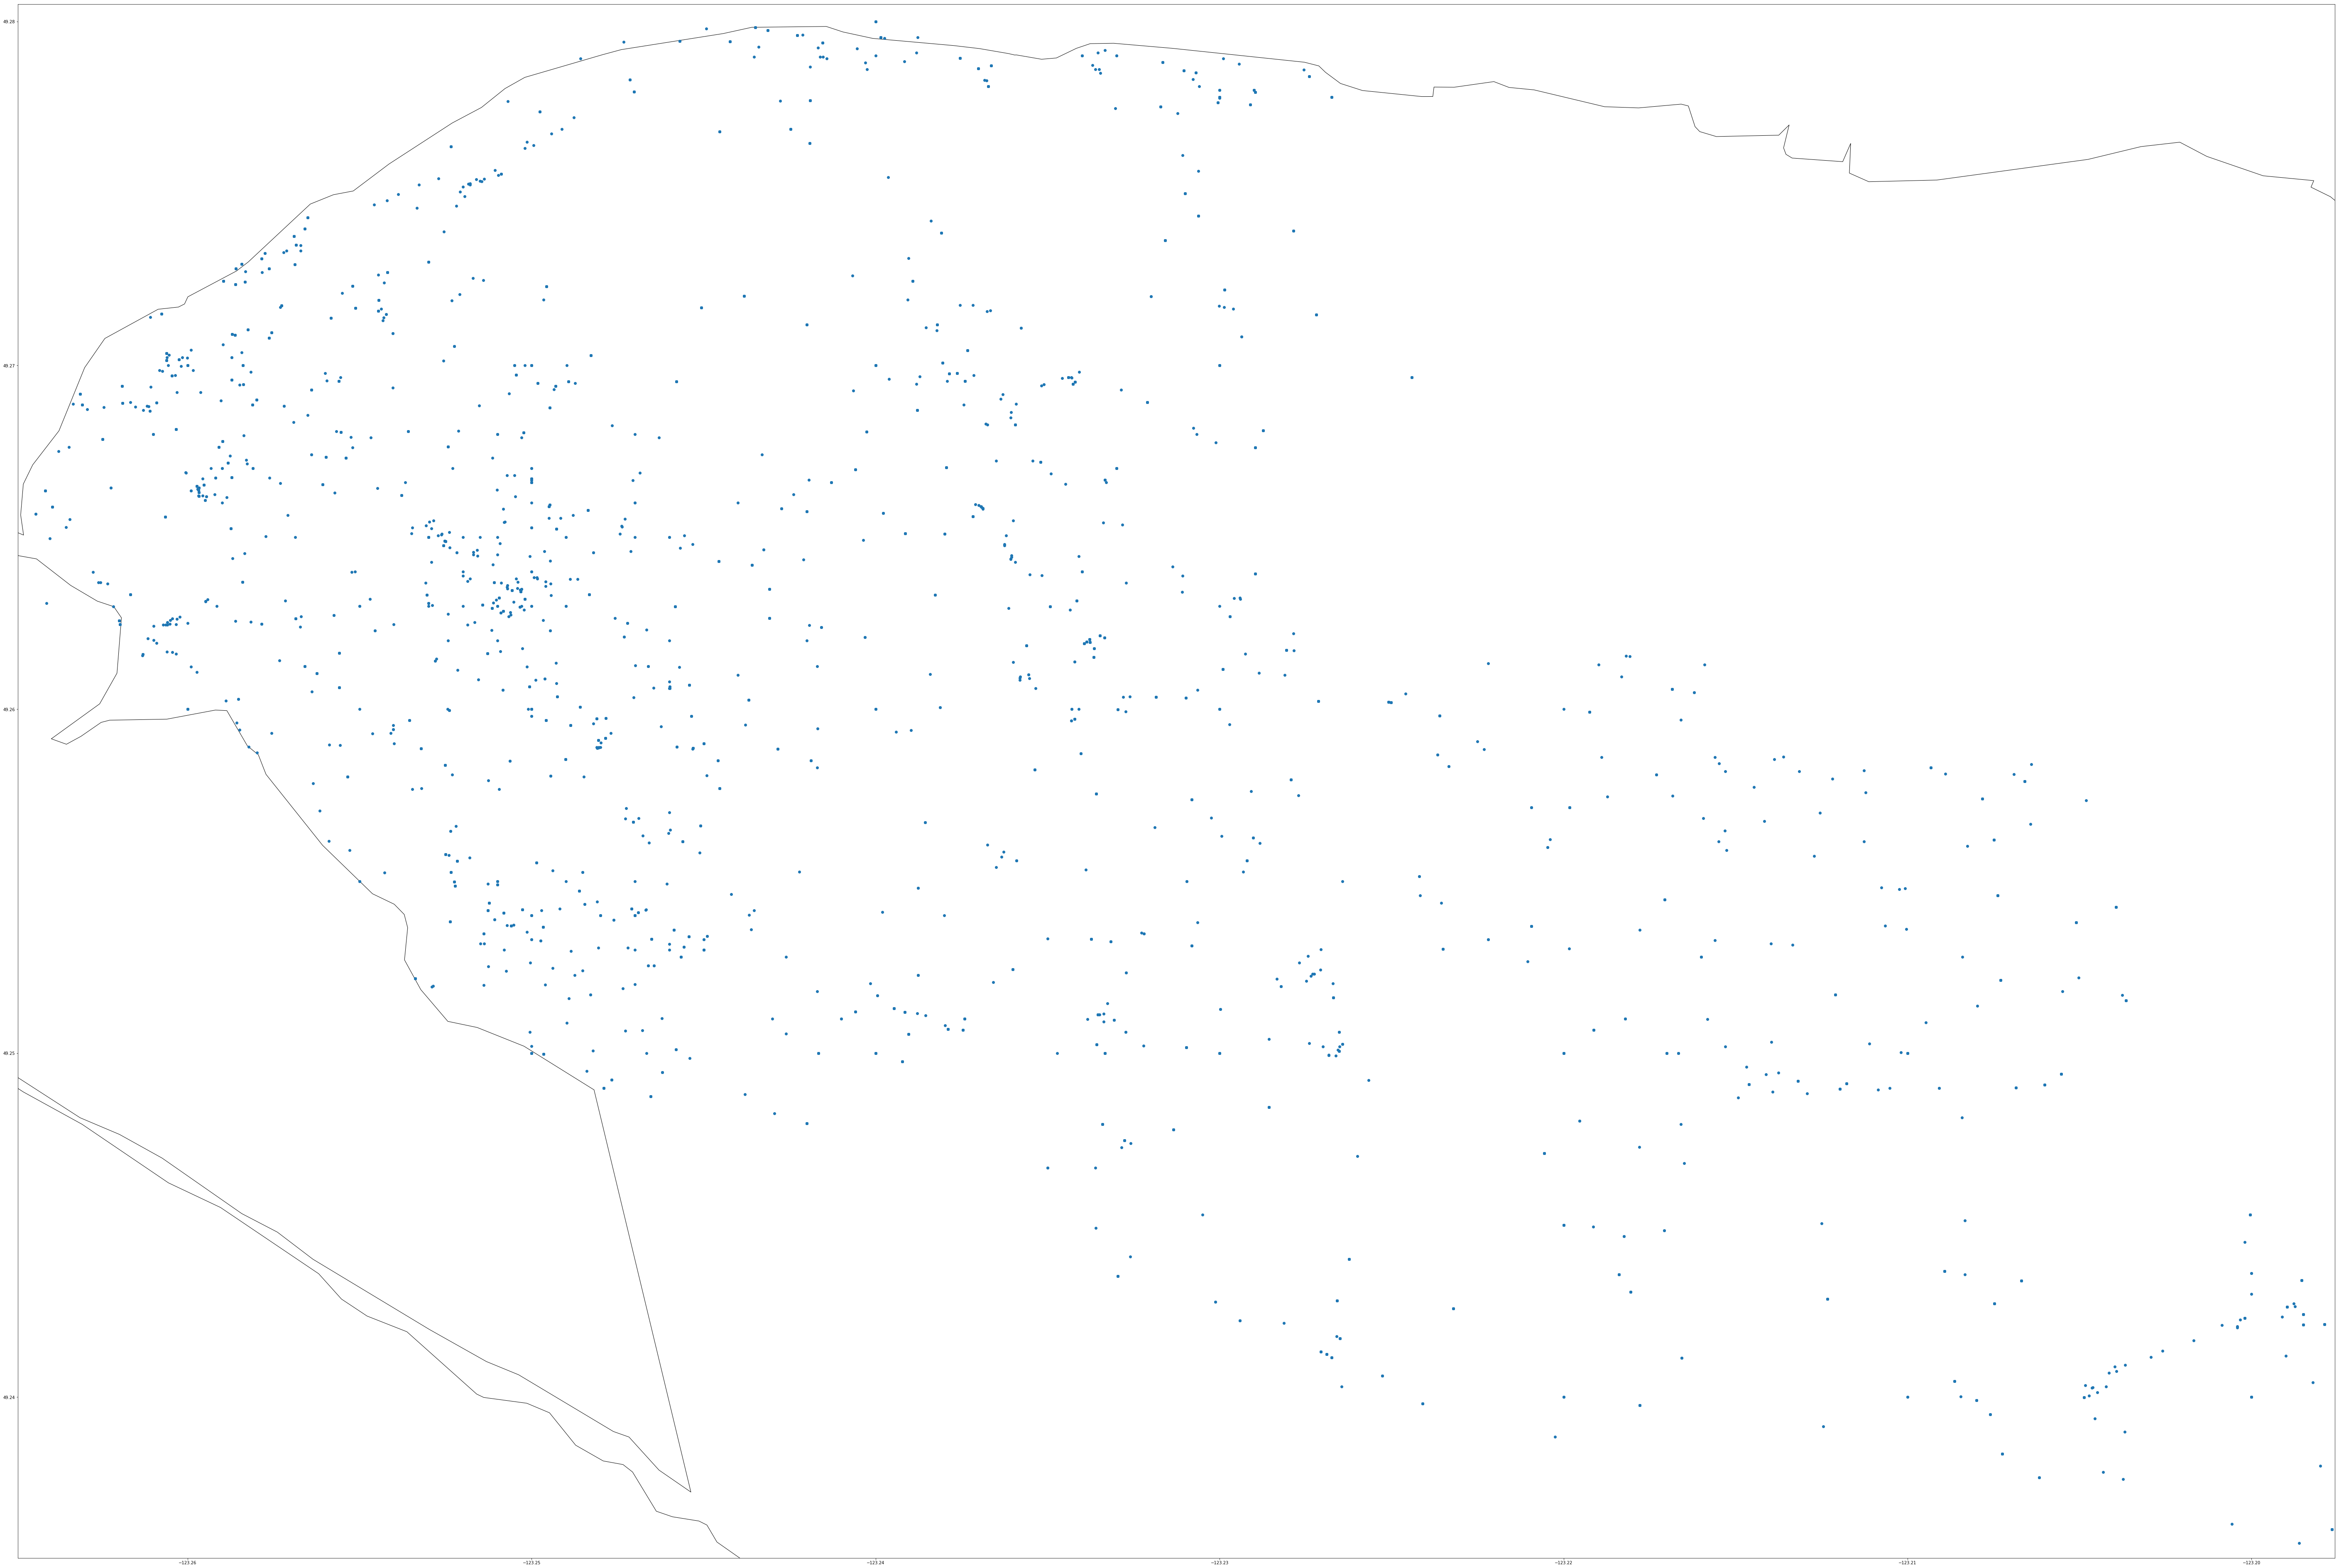

In [6]:
fig, ax = plt.subplots(figsize = (100,100))
ax.set_ylim(min_lat, max_lat)
ax.set_xlim(min_long, max_long)
# TODO: Make the boundries darker
van.plot(ax = ax, color='white', edgecolor='black',)
df_to_geodf(df_UBC).plot(ax = ax)

<h3> Digging deeper </h3>

<h4> 81794 Examples </h4>

* Every example has Lat, Long, scientificName
* 6512 groups based on scientificName
* 5 examples don't have kingdom
* 10 examples don't have phylum
* 12 examples don't have class
* 12 examples don't have order
* 32 examples don't have family
* 91 examples don't have genus
* 2062 examples don't have species

<h3> Red Lists </h3>

In [7]:
df_red = pd.read_csv("redlist_assessments.csv")

# Assume: RedList scientific correspond to UBC species
red_sciNames = df_red.scientificName

In [8]:
df_UBC_red = df_UBC[df_UBC['species'].isin(red_sciNames)]

In [9]:
UBC_red_groups = df_UBC_red.groupby('species').size().sort_values(ascending=False)
UBC_red_groups

species
Selasphorus rufus           630
Podiceps auritus            400
Hesperiphona vespertina     179
Cypseloides niger           123
Contopus cooperi             80
Brachyramphus marmoratus     67
Clangula hyemalis            66
Tsuga canadensis             10
Taxus brevifolia              5
Sequoia sempervirens          4
Fraxinus americana            4
Chamaecyparis lawsoniana      4
Fraxinus nigra                3
Calidris pusilla              3
Fraxinus pennsylvanica        2
Ilex collina                  2
Galanthus nivalis             2
Pinus coulteri                2
Cupressus bakeri              2
Coreopsis rosea               1
Bombus occidentalis           1
Tsuga caroliniana             1
Cupressus macrocarpa          1
Fraxinus latifolia            1
Fraxinus quadrangulata        1
Lupinus rivularis             1
Picea breweriana              1
Somateria mollissima          1
Abies fraseri                 1
dtype: int64

In [10]:
df_UBC_red_top = df_UBC_red[df_UBC_red['species'] == UBC_red_groups.index[0]]

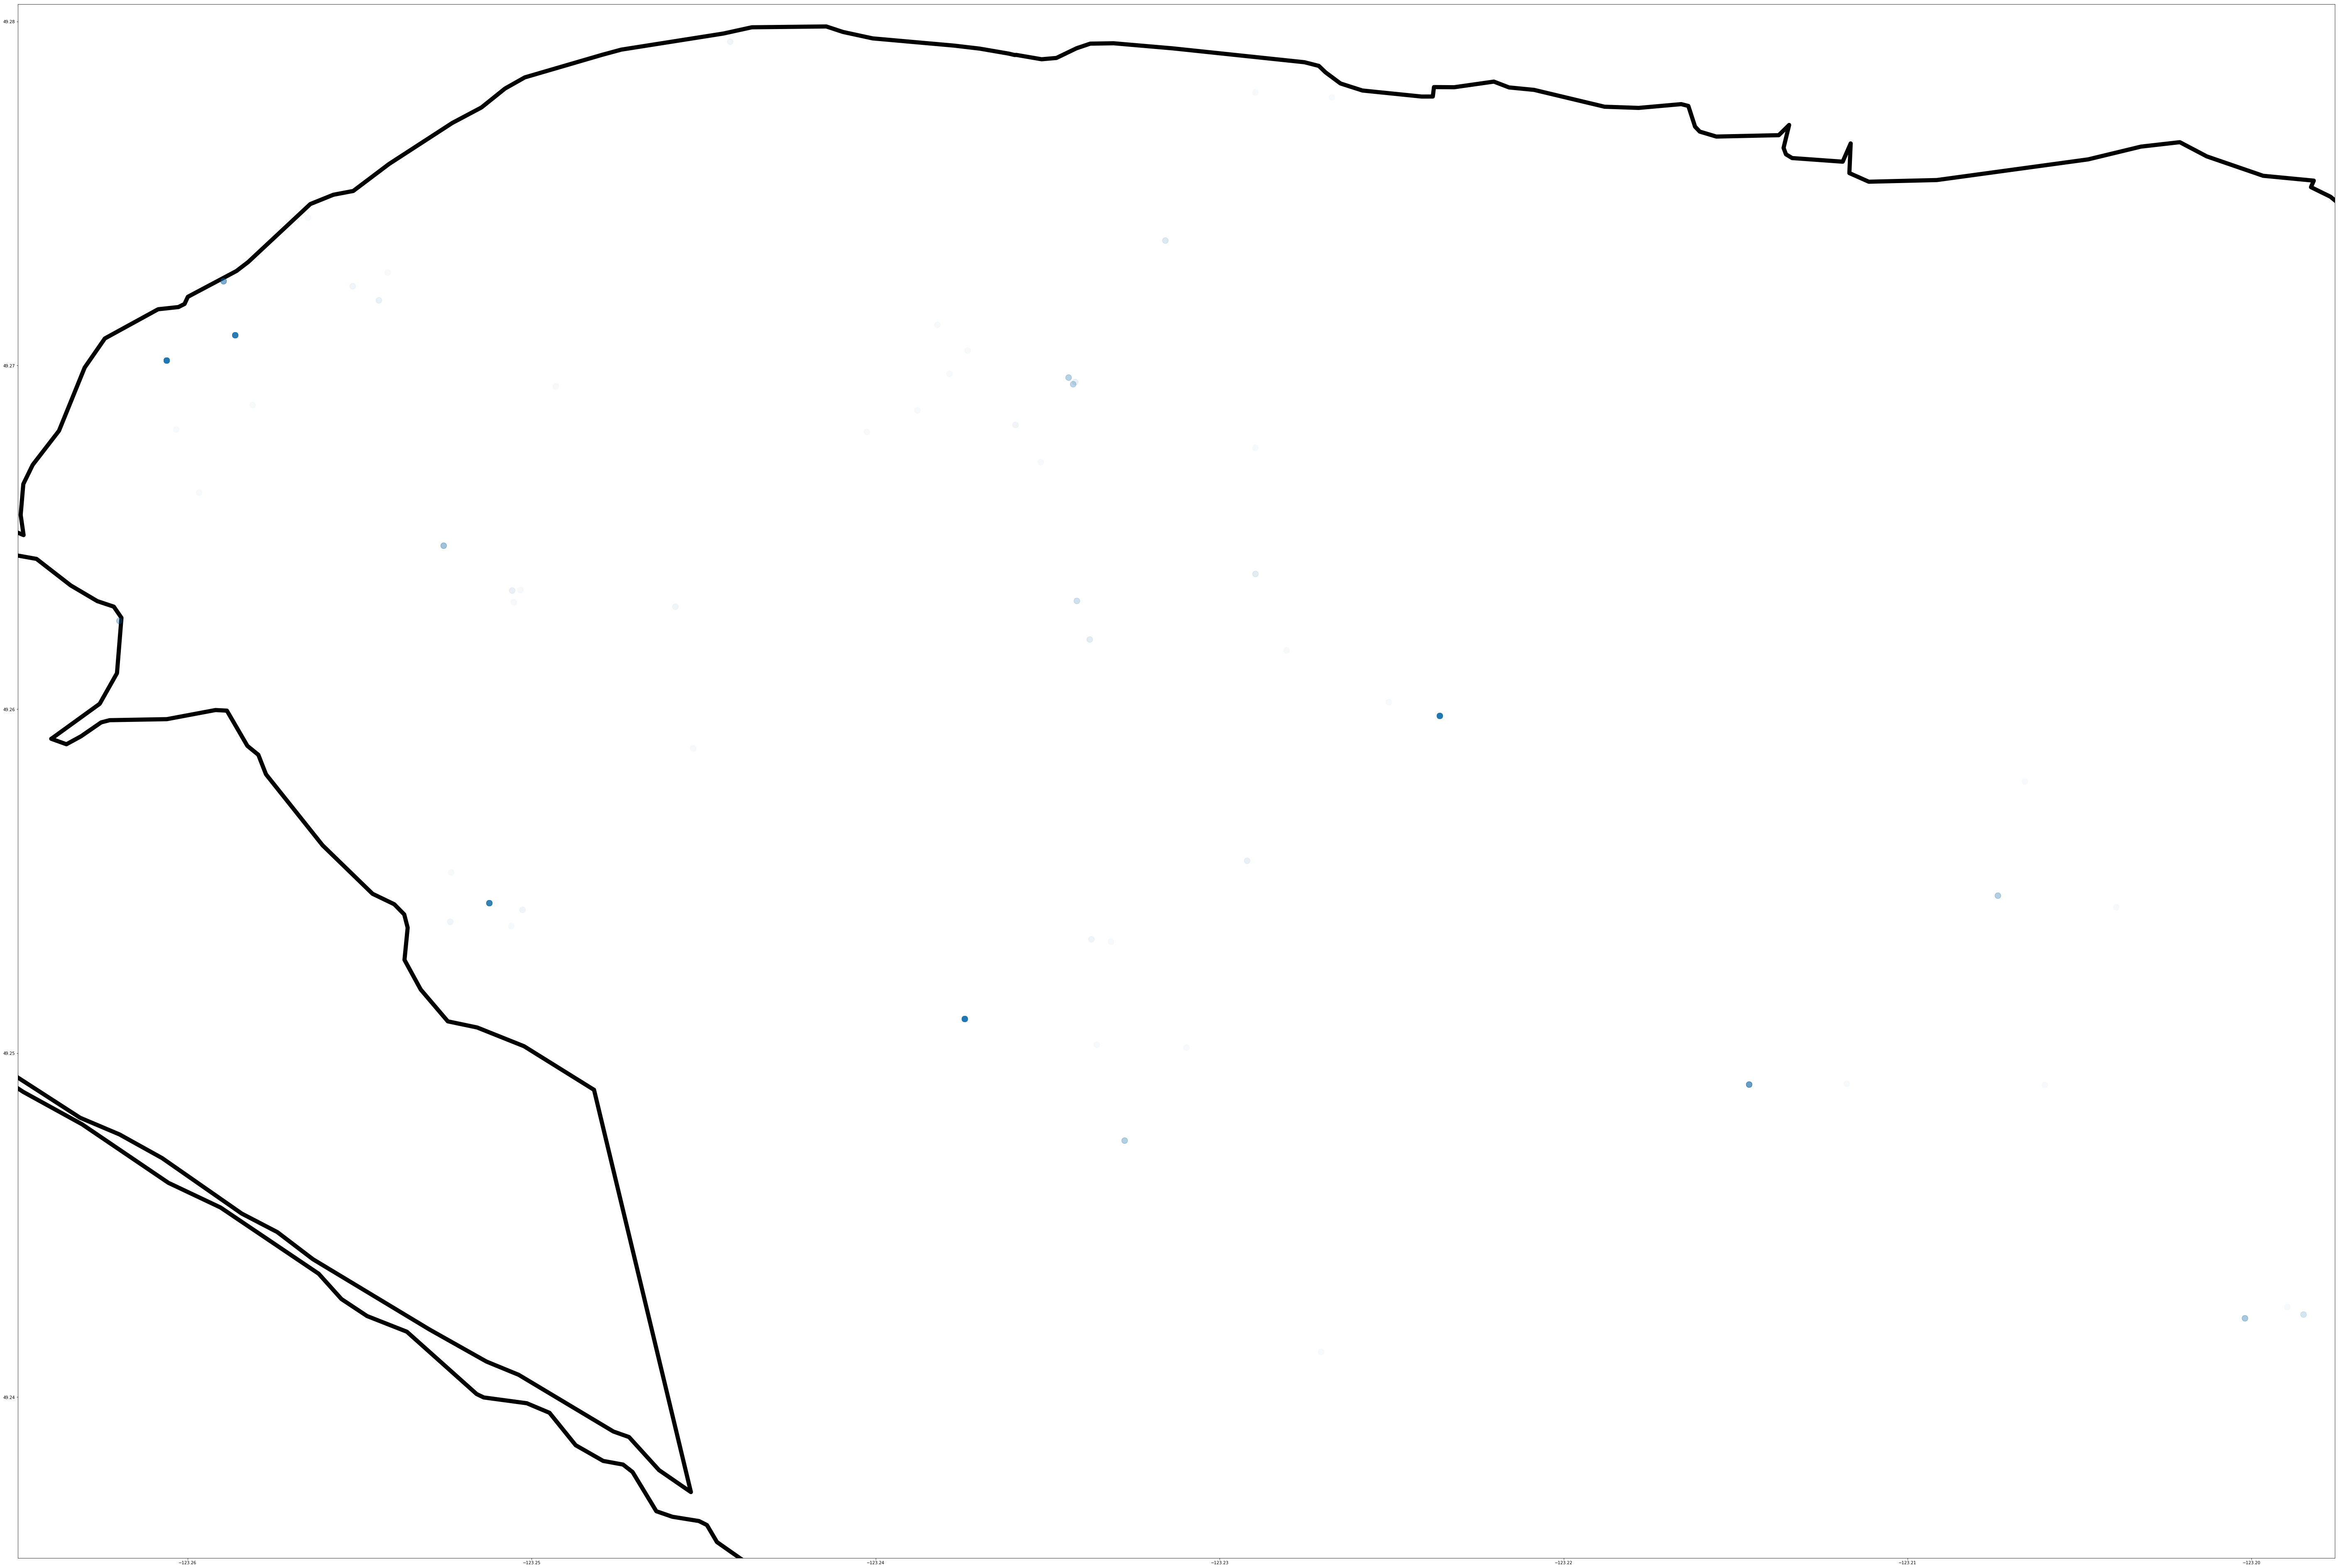

In [135]:
fig, ax = plt.subplots(figsize = (100,100))
ax.set_ylim(min_lat, max_lat)
ax.set_xlim(min_long, max_long)
# TODO: Make the boundries darker
van.plot(ax = ax, color='white', edgecolor='black', linewidth = 10)
df_to_geodf(df_UBC_red_top).plot(ax = ax, markersize = 200, alpha=0.03)

<h3> Form clusters on the map to identify museums, parks, etc. </h3>

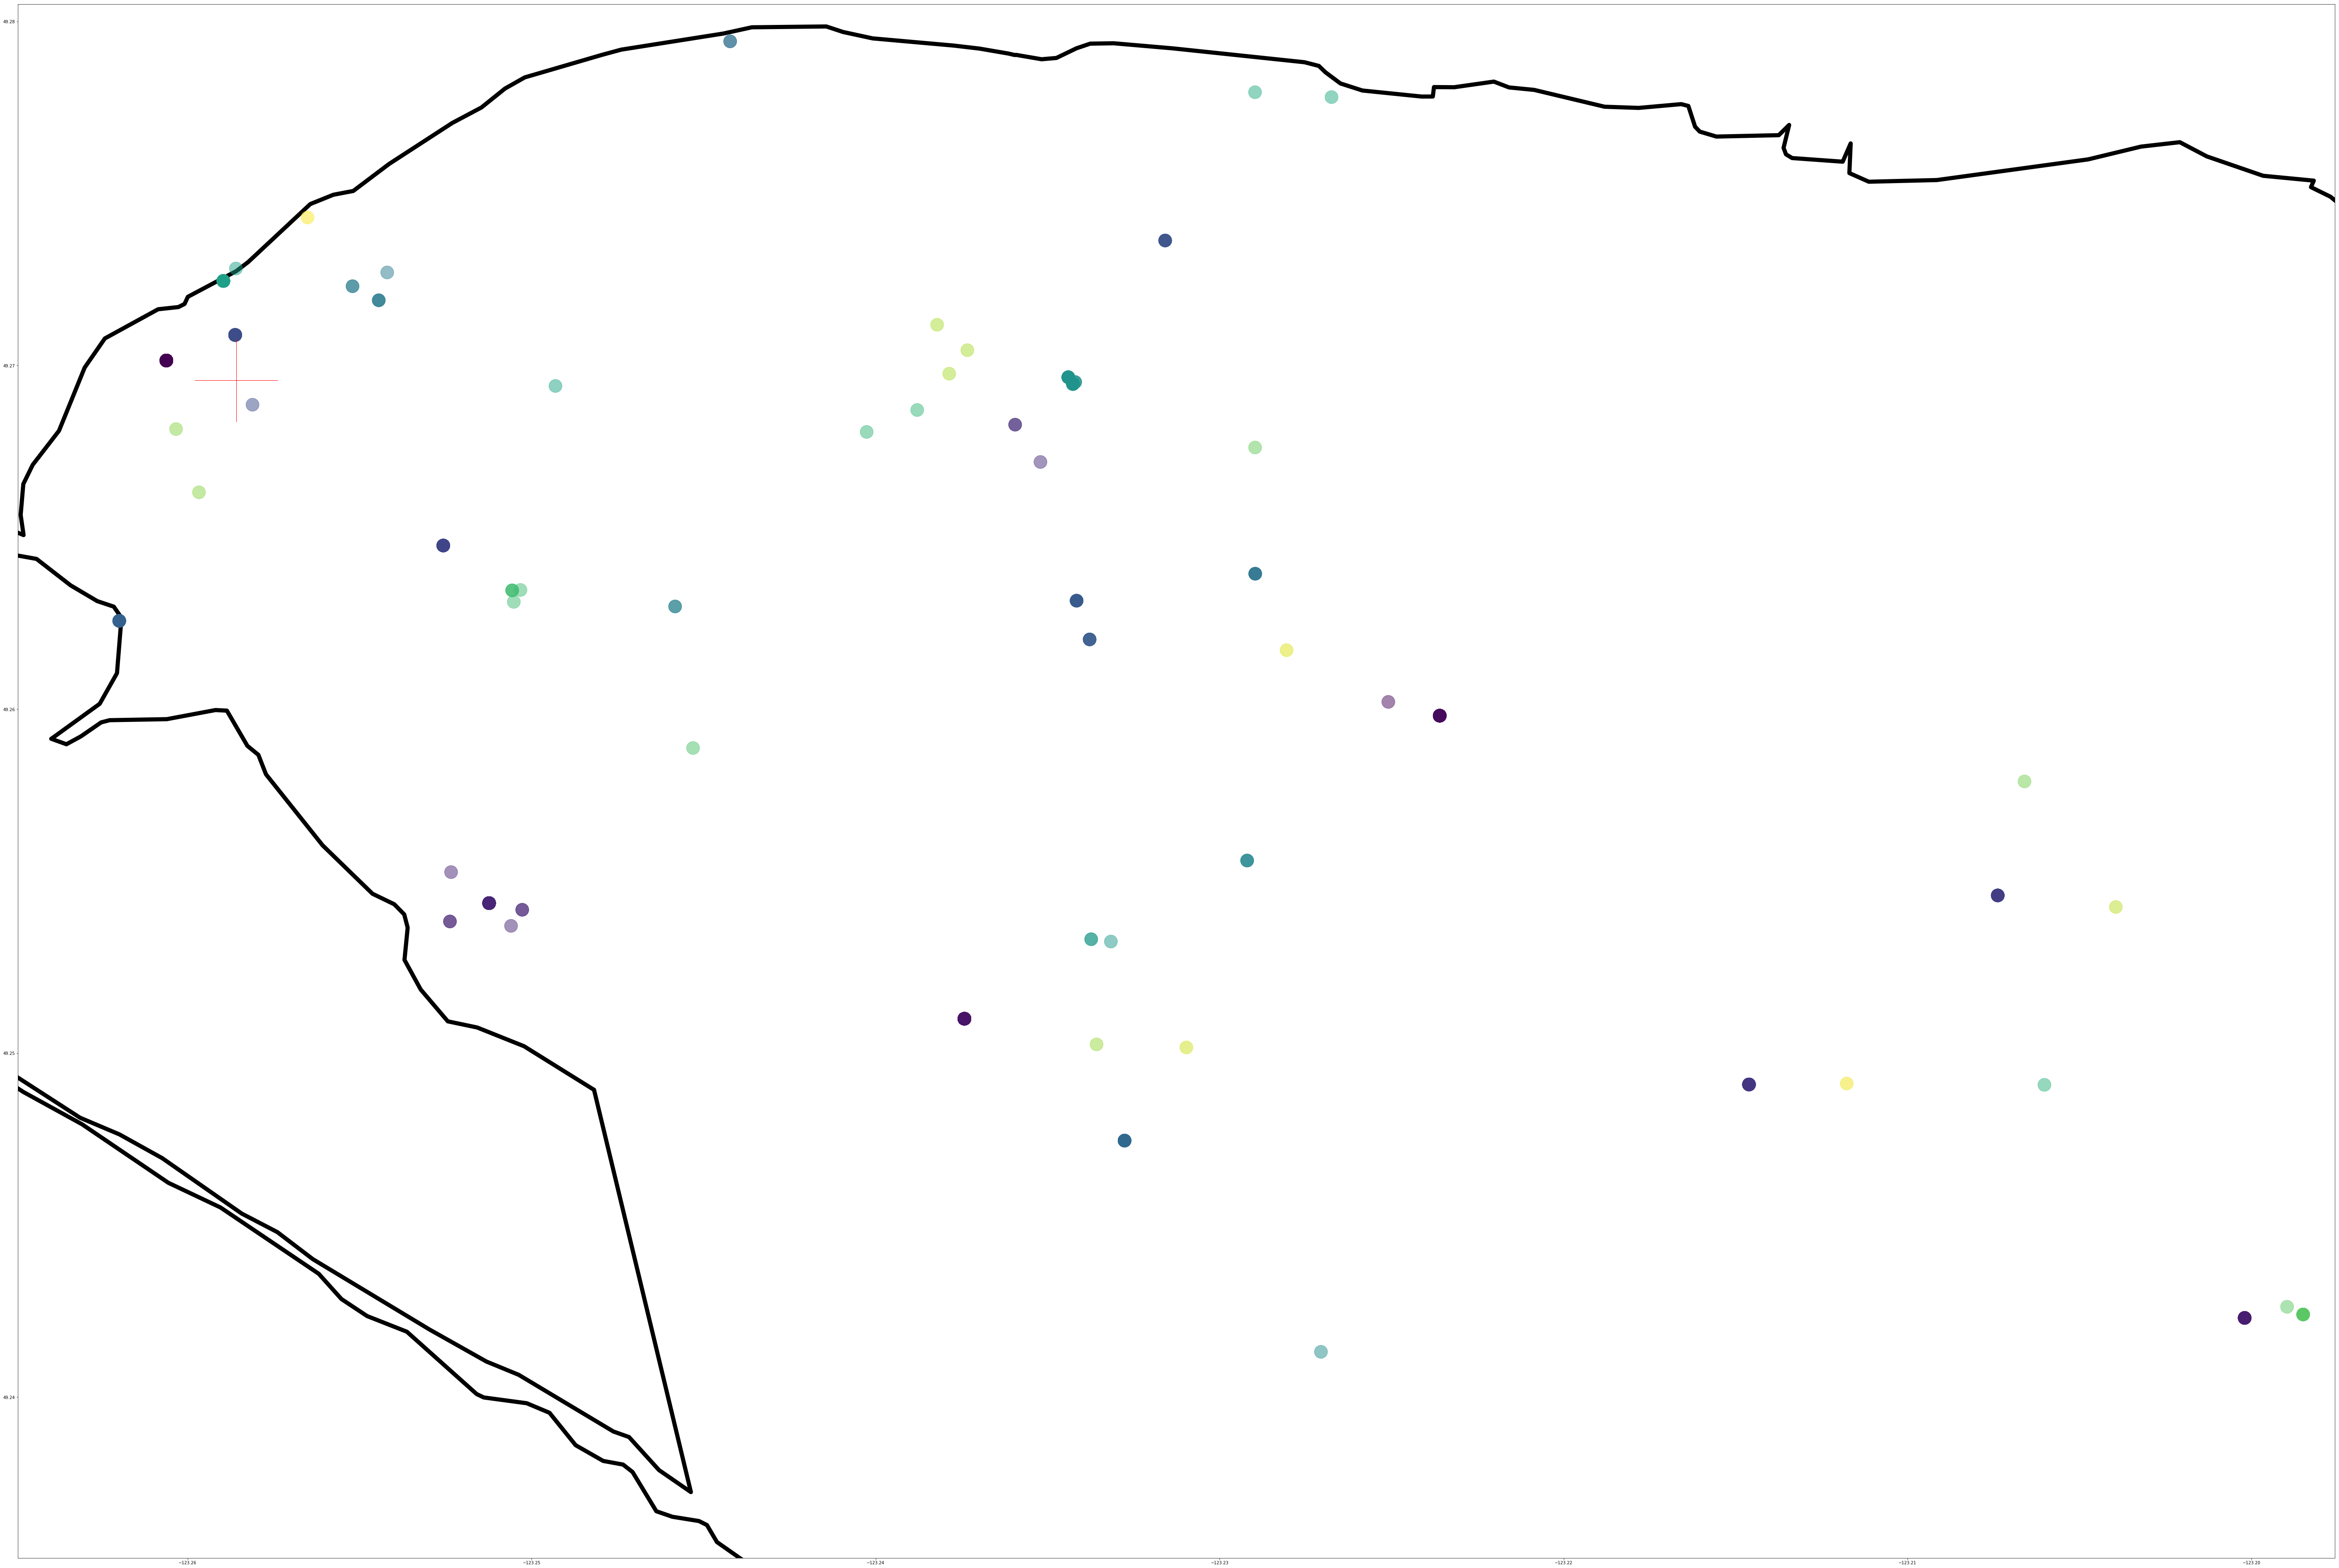

In [12]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Data = {'x': list(df_UBC_red_top.decimalLongitude.get_values()),
        'y': list(df_UBC_red_top.decimalLatitude.get_values())
       }
  
df = DataFrame(Data,columns=['x','y'])
  
kmeans = KMeans(n_clusters=40).fit(df)
centroids = kmeans.cluster_centers_
# print(centroids)

fig, ax = plt.subplots(figsize = (100,100))
ax.set_ylim(min_lat, max_lat)
ax.set_xlim(min_long, max_long)
# TODO: Make the boundries darker
van.plot(ax = ax, color='white', edgecolor='black', linewidth = 10)
# df_to_geodf(df_UBC_red_top).plot(ax = ax, markersize = 200)

plt.scatter(df['x'], df['y'], c= kmeans.labels_.astype(float), s=1000, alpha=0.5,)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=1000, )

plt.plot(-123.258591, 49.269565, 'r+', markersize =200)

<h3> Highlight hotspots </h3>

In [129]:

import unionfind as uf

inf = float("inf")
thresh = (0.000300)**2

def dist(p1, p2):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

def in_thresh(distance):
    return distance <= thresh

def createSets(df):
    indexes = df.index.to_list()
    coords = df.geometry.to_list()
    coords = map(lambda x: (x.x, x.y), coords)
    indexed_coordinates = [(a, b) for a,b in zip(indexes, coords)]
    point_sets = uf.UnionFind(indexes)
    
    for prim_element in indexed_coordinates:
        prim_key = prim_element[0]
        prim_val = prim_element[1]
        smallest_distance = inf
        union_index = prim_key
        for element in indexed_coordinates:
            key = element[0]
            val = element[1]
            if (key != prim_key):
                distance = dist(prim_val, val)
                if (in_thresh(distance) and distance <= smallest_distance):
                    smallest_distance = distance
                    union_index = key
        point_sets.union(prim_key, union_index)
        
    return point_sets
        

In [130]:
disjointSets = createSets(df_UBC_red_top)
components = disjointSets.components()
disjointSets.n_comps

61

In [ ]:
# Fetch coordinates at this point, average them, and plot as number of points

In [136]:
def av_and_weigh(df, components):
    x = []
    y = []
    
    weights = [len(comp) for comp in components]
    
    for i in range(len(components)):
        x.append(df.loc[list(components[i])].decimalLongitude.mean())
        y.append(df.loc[list(components[i])].decimalLatitude.mean())

    return (x, y, weights)
    
    
def labels(df, components):
    
    lab = [len(comp) for comp in components]
    
    return lab 

In [139]:
x, y, weights = av_and_weigh(df_UBC_red_top, components)
plot_labels = labels(df_UBC_red_top, components)

In [157]:
x[6]

-123.25861999999984

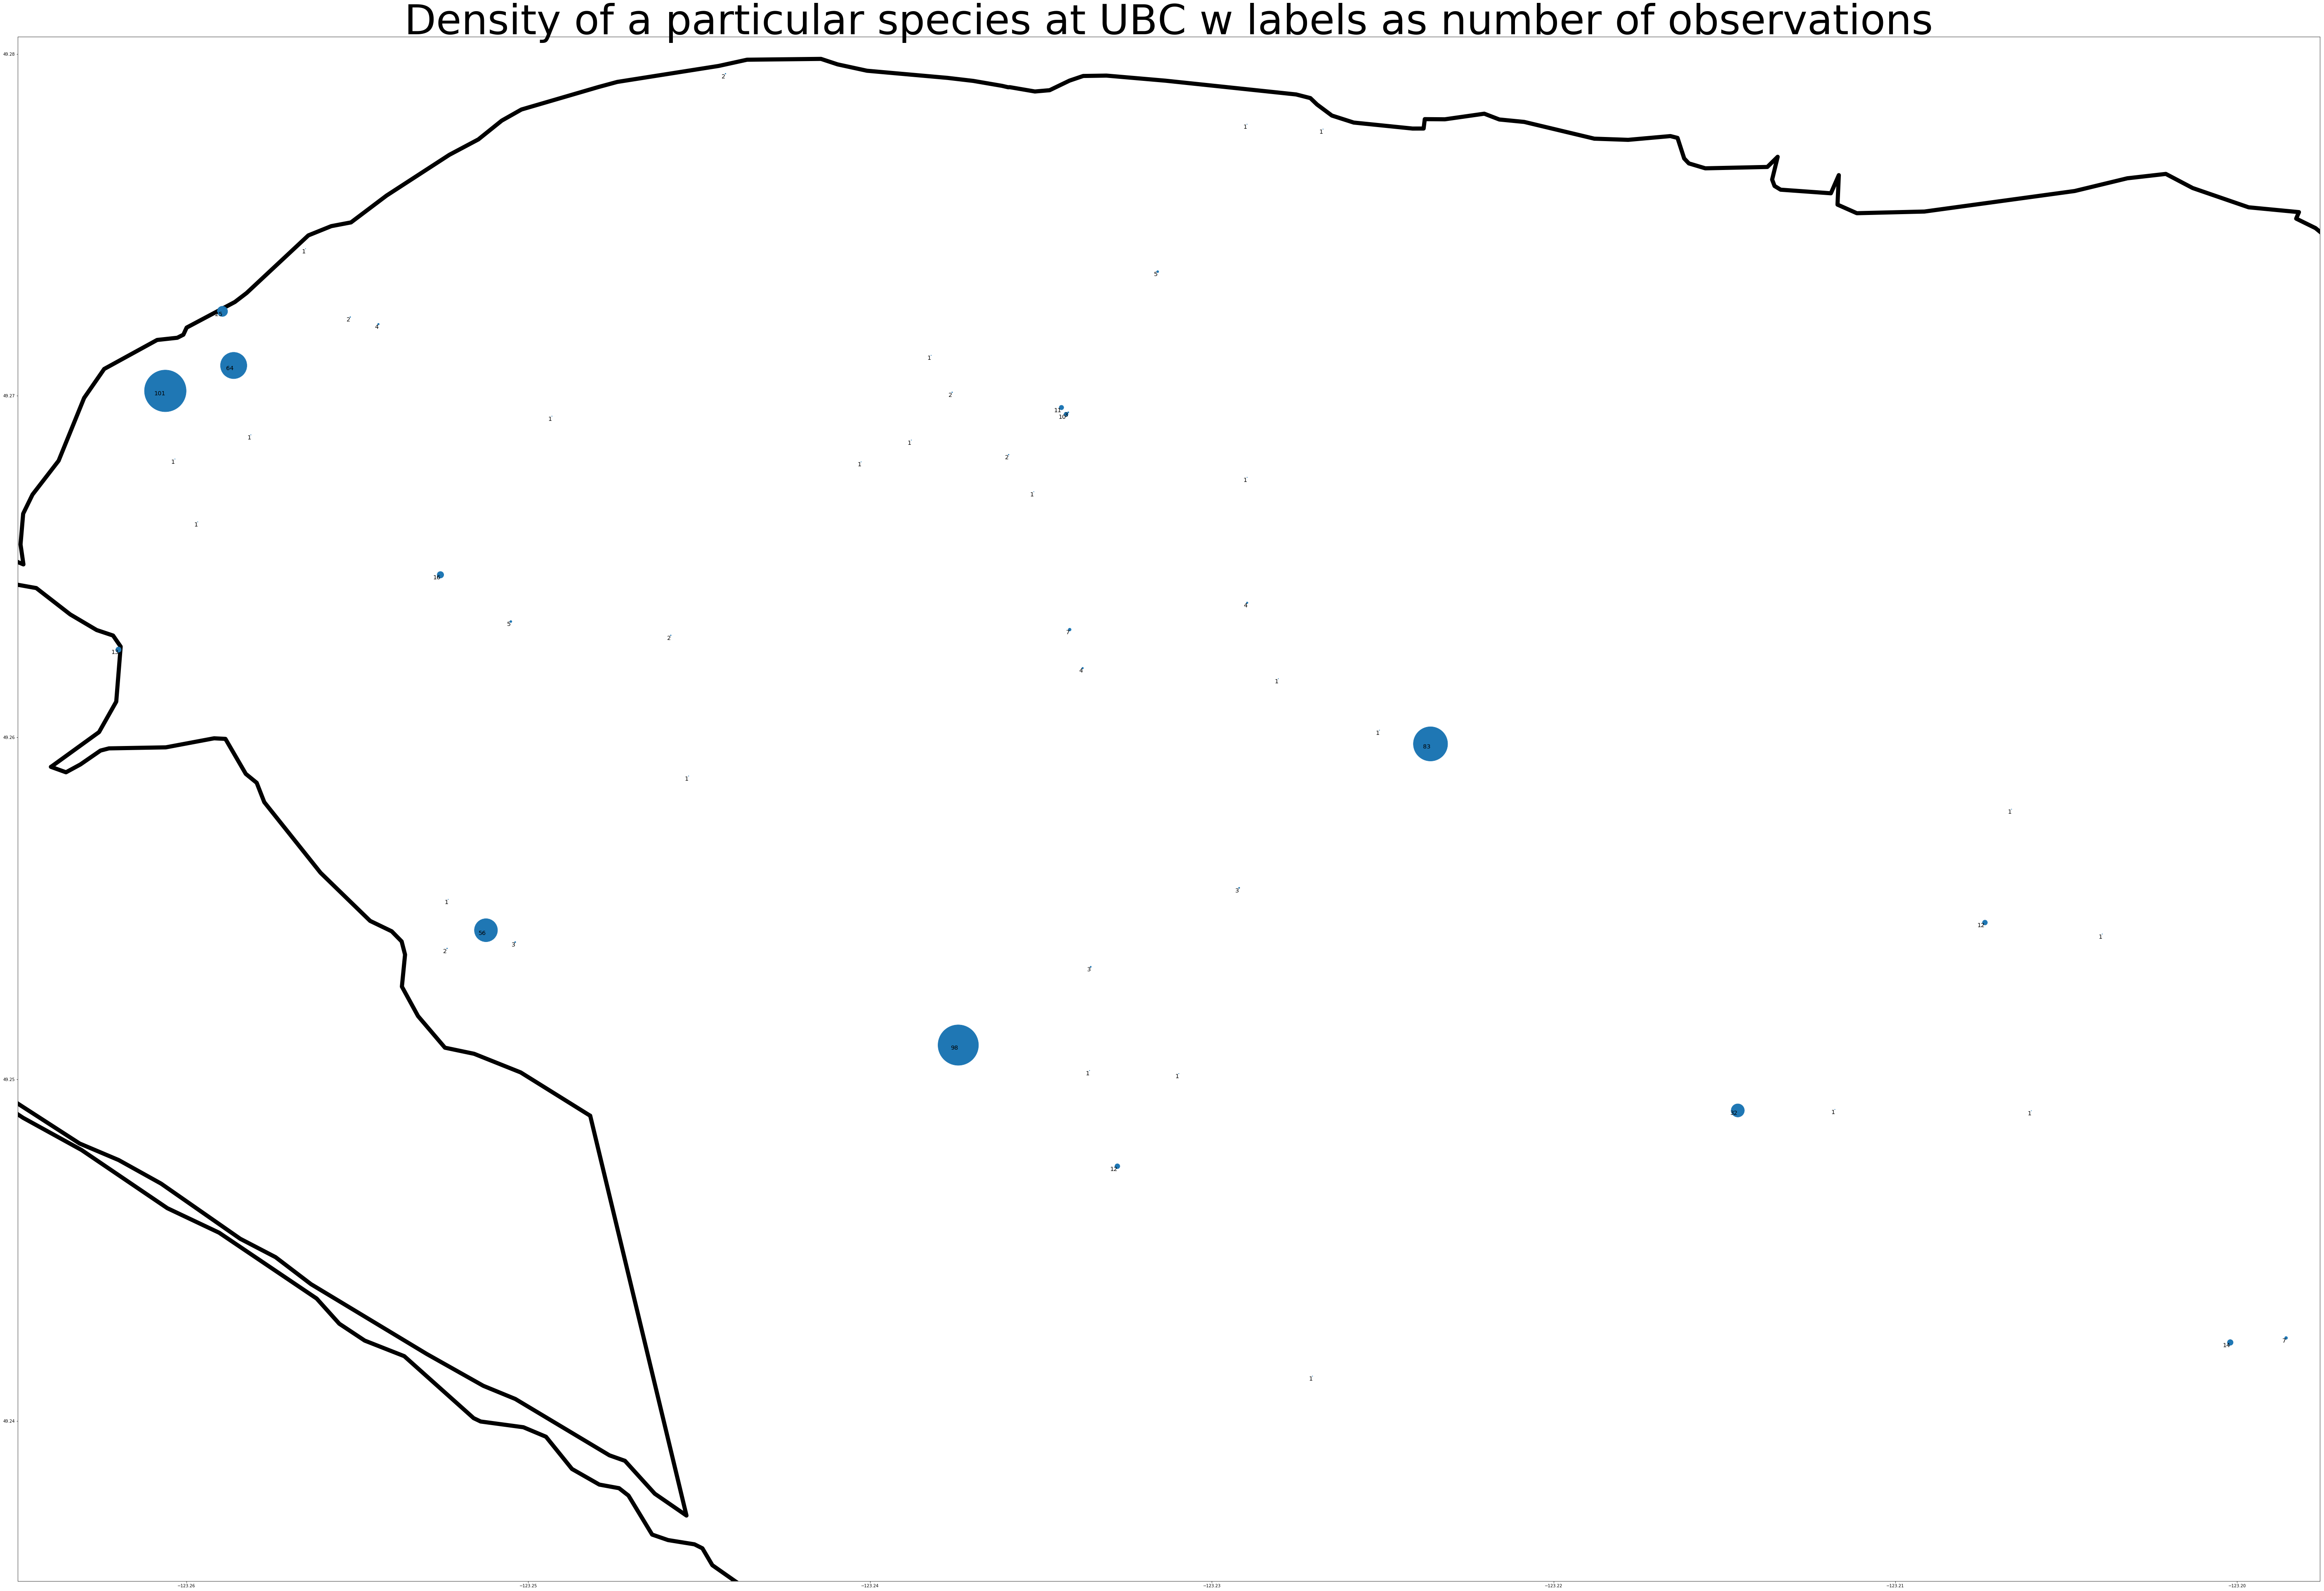

In [184]:
fig, ax = plt.subplots(figsize = (100,100))
ax.set_ylim(min_lat, max_lat)
ax.set_xlim(min_long, max_long)
# TODO: Make the boundries darker
van.plot(ax = ax, color='white', edgecolor='black', linewidth = 10)
plt.scatter(x,y, s = [i*i for i in weights])
plt.title("Density of a particular species at UBC w labels as number of observations", {'fontsize': 100,})
for i, txt in enumerate(plot_labels):
    ax.annotate(txt, (x[i], y[i]),
            horizontalalignment='right', verticalalignment='top', size = "x-large"
            )
# arrowprops=dict(facecolor='black', shrink=0.05)

<h3> Taxonomy charts </h3>

In [190]:
import plotly

In [185]:
# Check for overlapping coordinates

pos_groups = df_trimmed.groupby(['decimalLatitude', 'decimalLongitude'])
max_occuring_coords = pos_groups.size().sort_values(ascending=False)
# max_occuring_coords

In [186]:
df_UBC_red_top[(df_UBC_red_top['decimalLongitude'] == -123.260620) & 
               (df_UBC_red_top['decimalLatitude'] == 49.270140)].groupby('year').size().sort_values(ascending=False)
    
    

year
2015.0    24
2014.0    20
2017.0     9
2007.0     9
2012.0     7
2018.0     6
2013.0     5
2008.0     4
2016.0     3
2005.0     3
2001.0     3
2011.0     2
1999.0     2
2006.0     1
2002.0     1
2000.0     1
1987.0     1
dtype: int64

In [176]:
df_UBC_red_top[df_UBC_red_top['eventDate'] == "2014-05-01T00:00:00Z"].lastInterpreted

38847    2019-03-27T20:12:59.495Z
47782    2019-03-27T16:00:29.636Z
48012    2019-03-27T15:57:47.556Z
Name: lastInterpreted, dtype: object

In [166]:
df.columns

Index([u'gbifID', u'datasetKey', u'occurrenceID', u'kingdom', u'phylum',
       u'class', u'order', u'family', u'genus', u'species',
       u'infraspecificEpithet', u'taxonRank', u'scientificName',
       u'countryCode', u'locality', u'publishingOrgKey', u'decimalLatitude',
       u'decimalLongitude', u'coordinateUncertaintyInMeters',
       u'coordinatePrecision', u'elevation', u'elevationAccuracy', u'depth',
       u'depthAccuracy', u'eventDate', u'day', u'month', u'year', u'taxonKey',
       u'speciesKey', u'basisOfRecord', u'institutionCode', u'collectionCode',
       u'catalogNumber', u'recordNumber', u'identifiedBy', u'dateIdentified',
       u'license', u'rightsHolder', u'recordedBy', u'typeStatus',
       u'establishmentMeans', u'lastInterpreted', u'mediaType', u'issue',
       u'geometry'],
      dtype='object')

In [ ]:
max_occuring_coord = max_occuring_coords.index[0]

In [ ]:

# df_pruned = df_UBC_red_top[df_UBC_red_top.apply(lambda x: 
#                                     x['geometry'].coords[0][0] >= min_long and x['geometry'].coords[0][0] <= max_long
#                                     and x['geometry'].coords[0][1] >= min_lat and x['geometry'].coords[0][1] <= max_lat, axis = 1)]


In [ ]:
df_repeat = df_UBC_red_top[(df_UBC_red_top['decimalLatitude'] == max_occuring_coord[0]) & (df_UBC_red_top['decimalLongitude'] == max_occuring_coord[1])]


In [ ]:
df_repeat.locality.unique()

In [ ]:
df_repeat.groupby('year').size().sort_values(ascending=False)